Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [11]:
class InvestmentAnalyzer:
    def __init__(self, investment_amount, annual_rate, early_redemption_barrier, coupon_payment_barrier, final_barrier, checkpoints):
        self.investment_amount = investment_amount
        self.annual_rate = annual_rate
        self.quarterly_rate = annual_rate / 4
        self.early_redemption_barrier = early_redemption_barrier
        self.coupon_payment_barrier = coupon_payment_barrier
        self.final_barrier = final_barrier
        self.checkpoints = checkpoints

    def fetch_data(self, tickers, start, end):
        price_data = {}
        for ticker in tickers:
            price_data[ticker] = yf.download(ticker, start=start, end=end)['Close']
        return pd.DataFrame(price_data)

    def analyze_worst_performance(self, price_data, start_prices):
        start_prices = pd.Series(start_prices)
        worst_ratios, worst_tickers, lowest_prices, critical_dates = [], [], [], []

        for i in range(1, len(self.checkpoints)):
            segment_data = price_data.loc[self.checkpoints[i-1]:self.checkpoints[i]]
            segment_min = segment_data.min(axis=0)
            relative_performance = segment_min / start_prices
            worst_ticker = relative_performance.idxmin()

            worst_ratios.append(relative_performance.min())
            worst_tickers.append(worst_ticker)
            lowest_prices.append(segment_data[worst_ticker].min())
            critical_dates.append(segment_data[worst_ticker].idxmin())

        return worst_ratios, worst_tickers, lowest_prices, critical_dates

    def compute_payout(self, worst_ratios):
        payouts = []
        total_result = 0
        is_redeemed = False
        event_log = []

        for i, ratio in enumerate(worst_ratios):
            if ratio >= self.early_redemption_barrier:
                total_result = self.investment_amount + self.investment_amount * self.quarterly_rate * (i + 1)
                payouts.append(self.quarterly_rate * (i + 1))
                event_log.append(f"Early redemption ({self.checkpoints[i]})")
                is_redeemed = True
                break
            elif ratio >= self.coupon_payment_barrier:
                payouts.append(self.quarterly_rate)
                event_log.append(f"Coupon payment ({self.checkpoints[i]})")
            else:
                payouts.append(0)
                event_log.append(f"No coupon ({self.checkpoints[i]})")

        if not is_redeemed:
            if worst_ratios[-1] >= self.final_barrier:
                total_result = self.investment_amount + self.investment_amount * sum(payouts)
                event_log.append(f"Final redemption with nominal return ({self.checkpoints[-1]})")
            else:
                total_result = self.investment_amount * worst_ratios[-1]
                event_log.append(f"Final redemption with reduced payout ({self.checkpoints[-1]})")

        return total_result, payouts, event_log

    def compute_mean_performance(self, price_data, start_prices):
        start_prices = pd.Series(start_prices)
        mean_performances = []

        for i in range(1, len(self.checkpoints)):
            segment_data = price_data.loc[self.checkpoints[i-1]:self.checkpoints[i]]
            relative_means = segment_data.mean(axis=0) / start_prices
            mean_performances.append(relative_means.mean())

        return mean_performances

    def visualize_results(self, price_data, start_prices, lowest_prices, worst_tickers, critical_dates):
        plt.figure(figsize=(16, 8))
        for ticker in price_data.columns:
            plt.plot(price_data.index, price_data[ticker] / start_prices[ticker] * 100, label=ticker)

        for checkpoint in self.checkpoints:
            plt.axvline(pd.to_datetime(checkpoint), color='purple', linestyle='--', alpha=0.7, label='Checkpoints' if checkpoint == self.checkpoints[0] else "")

        performance_percentages = [
            (price / start_prices[ticker]) * 100 for price, ticker in zip(lowest_prices, worst_tickers)
        ]
        plt.scatter(critical_dates, performance_percentages, color='orange', label='Worst Performers', zorder=5)

        for date, percent, ticker in zip(critical_dates, performance_percentages, worst_tickers):
            plt.text(date, percent, ticker, fontsize=9, ha='right', va='bottom')

        plt.axhline(self.early_redemption_barrier * 100, color='green', linestyle='--', label='Early Redemption Barrier')
        plt.axhline(self.coupon_payment_barrier * 100, color='blue', linestyle='--', label='Coupon Payment Barrier')
        plt.axhline(self.final_barrier * 100, color='red', linestyle='--', label='Final Barrier')

        plt.title('Asset Performance and Key Barriers')
        plt.xlabel('Date')
        plt.ylabel('Price (% of Initial)')
        plt.legend()
        plt.show()

    def plot_avg_performance_graph(self, mean_performances):
        performance_percentages = [mp * 100 for mp in mean_performances]

        plt.figure(figsize=(12, 6))
        plt.plot(self.checkpoints[1:], performance_percentages, color='purple', label='Mean Performance', linestyle='-', marker='o')

        plt.xlabel('Observation Dates')
        plt.ylabel('Mean Performance (%)')
        plt.title('Average Performance of Assets Over Time')

        for i, value in enumerate(performance_percentages):
            plt.text(self.checkpoints[i + 1], value, f'{value:.2f}', fontsize=9, ha='center', va='bottom')

        plt.axhline(y=self.early_redemption_barrier * 100, color='red', linestyle='--', label='Early Redemption Barrier')
        plt.axhline(y=self.coupon_payment_barrier * 100, color='blue', linestyle='--', label='Coupon Payment Barrier')
        plt.axhline(y=self.final_barrier * 100, color='green', linestyle='--', label='Final Barrier')

        plt.legend()

        for date in self.checkpoints[1:]:
            plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

        plt.grid(alpha=0.6)
        plt.tight_layout()
        plt.show()

In [14]:
# Исходные параметры
investment_amount = 5000000  # Начальная сумма инвестиций
annual_rate = 0.2  # Годовая процентная ставка
early_redemption_barrier = 1.05  # Барьер досрочного погашения
coupon_payment_barrier = 0.98  # Барьер для выплаты купона
final_barrier = 0.90  # Финальный барьер
checkpoints = ['2022-07-27', '2022-10-25', '2023-01-25', '2023-04-25', '2023-07-25']  # Даты наблюдений

# Список тикеров
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NFLX', 'NVDA'
]

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Log:
No coupon (2022-07-27)
No coupon (2022-10-25)
No coupon (2023-01-25)
No coupon (2023-04-25)
Final redemption with reduced payout (2023-07-25)
Final Payout: 4444299.50 RUB


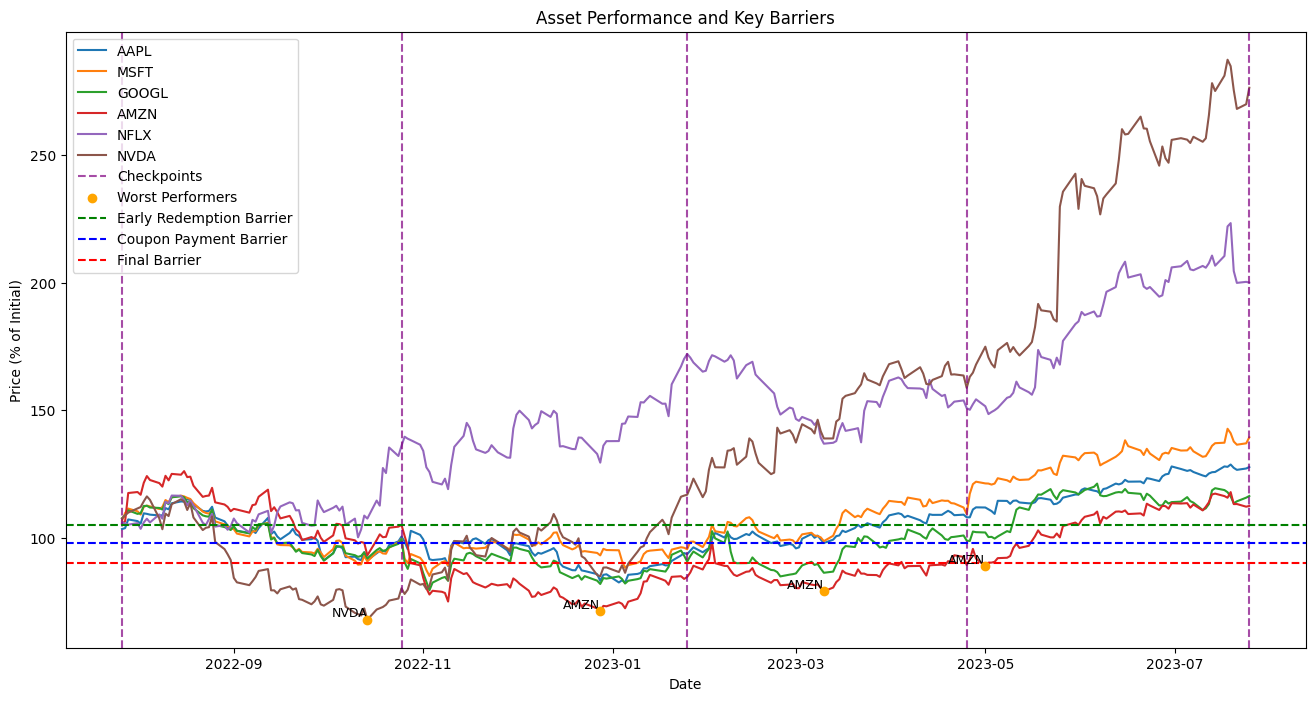

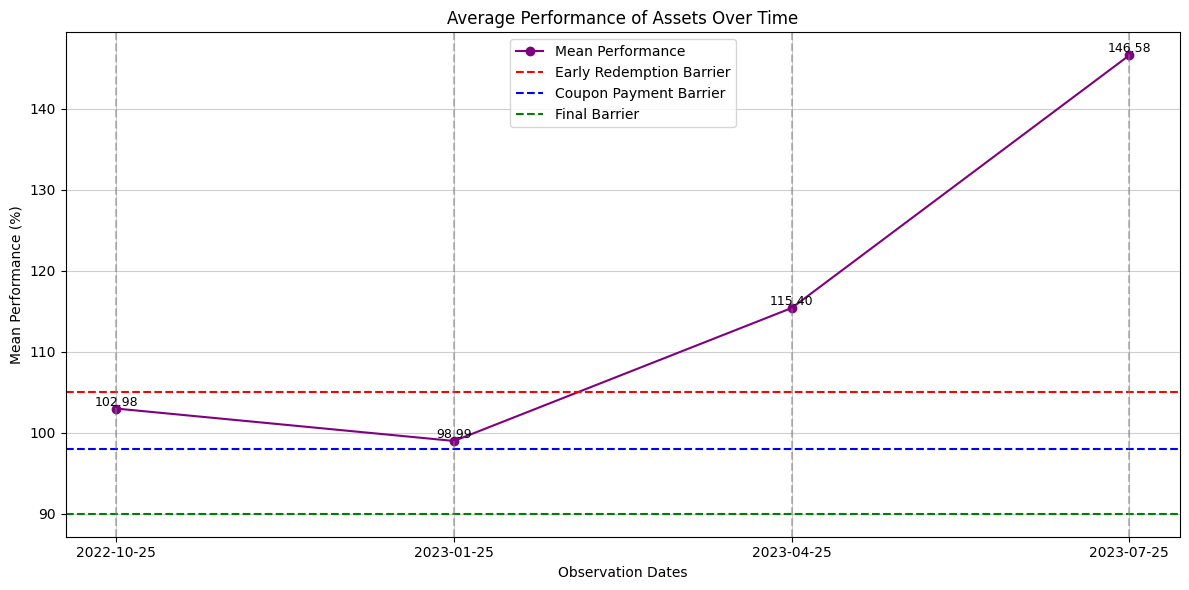

In [15]:
# Создаем экземпляр класса
analyzer = InvestmentAnalyzer(
    investment_amount=investment_amount,
    annual_rate=annual_rate,
    early_redemption_barrier=early_redemption_barrier,
    coupon_payment_barrier=coupon_payment_barrier,
    final_barrier=final_barrier,
    checkpoints=checkpoints
)

# Загрузка данных
price_data = analyzer.fetch_data(tickers, '2022-07-26', '2023-07-26')

# Извлечение начальных цен
start_prices = price_data.iloc[0].to_dict()

# Удаляем первый день (начальные данные не нужны для дальнейшего анализа)
price_data = price_data.iloc[1:]

# Анализ худшей производительности
worst_ratios, worst_tickers, lowest_prices, critical_dates = analyzer.analyze_worst_performance(price_data, start_prices)

# Расчет выплат
total_result, payouts, event_log = analyzer.compute_payout(worst_ratios)

# Вывод результатов анализа
print("Event Log:")
for event in event_log:
    print(event)
print(f"Final Payout: {total_result:.2f} RUB")

# Построение графика худшей производительности
analyzer.visualize_results(price_data, start_prices, lowest_prices, worst_tickers, critical_dates)

# Анализ средней производительности
mean_performances = analyzer.compute_mean_performance(price_data, start_prices)

# Построение графика средней производительности
analyzer.plot_avg_performance_graph(mean_performances)